In [ ]:

import os, sys, torch
from torch_geometric.transforms import ToUndirected

PROJECT_ROOT = os.path.abspath("..") 
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.load_graph_data import load_hetero_pt

from pathlib import Path
from torch_geometric.transforms import ToUndirected


if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    os.environ.setdefault('PYTORCH_ENABLE_MPS_FALLBACK', '1')
    DEVICE = torch.device("cpu")
print('Using device:', DEVICE)


data = load_hetero_pt()
data = ToUndirected()(data)

# Optional: drop unused nodes/edges
keep = ['email', 'sender', 'url', 'domain', 'stem', 'body_cluster', 'email_domain', 'receiver']
keep_set = set(keep)

for ntype in list(data.node_types):
    if ntype not in keep_set:
        del data[ntype]

for et in list(data.edge_types):
    src, rel, dst = et
    if src not in keep_set or dst not in keep_set:
        del data[et]





Using device: cpu


/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/load_graph_data.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_l

In [ ]:
from pathlib import Path
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

def list_saved_runs(models_dir="../models"):
    """
    Returns a list of all run directories (e.g., 'run-2025-12-09_18-42-00') under the models folder.
    """
    models_path = Path(models_dir)
    run_dirs = sorted([p for p in models_path.glob("run-*") if p.is_dir()])
    print(f"Found {len(run_dirs)} saved run(s):")
    for run in run_dirs:
        print(" -", run.name)
    return run_dirs

def list_saved_models(run_name, models_dir="../models"):
    """
    Given a run name (e.g., 'run-2025-12-09_18-42-00'), returns all model checkpoint files under that run folder.
    """
    run_path = Path(models_dir) / run_name
    if not run_path.exists():
        raise FileNotFoundError(f"Run directory not found: {run_path}")
    model_paths = sorted(run_path.glob("*.pt"))
    print(f"Found {len(model_paths)} model(s) in {run_name}:")
    for m in model_paths:
        print(" -", m.name)
    return model_paths

def compute_homogeneity_from_clusters(clusters, ground_truth):    
    email_to_predicted_cluster = {}
    for cluster_id, email_indices in clusters.items():
        for email_idx in email_indices:
            email_to_predicted_cluster[email_idx] = cluster_id
    
    common_emails = set(email_to_predicted_cluster.keys()) & set(ground_truth.keys())
    
    if len(common_emails) < 2:
        return {'homogeneity': 0.0, 'completeness': 0.0, 'v_measure': 0.0, 'n_samples': len(common_emails)}
    
    common_emails = sorted(common_emails)
    predicted_labels = [email_to_predicted_cluster[e] for e in common_emails]
    true_labels = [ground_truth[e] for e in common_emails]
    homogeneity = homogeneity_score(true_labels, predicted_labels)
    completeness = completeness_score(true_labels, predicted_labels)
    v_measure = v_measure_score(true_labels, predicted_labels)
    
    return {
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure,
        'n_samples': len(common_emails)
    }



In [ ]:
from pathlib import Path
import torch
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import re
import os, sys
from collections import defaultdict

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Load the vote file (already uploaded earlier)
vote_file_path = "campaigns.csv"
votes_df = pd.read_csv(vote_file_path)

def extract_ground_truth_labels(df: pd.DataFrame):
    label_map = {}
    for _, row in df.iterrows():
        raw_label = str(row.get("campaign_label", "")).strip()
        m = re.search(r"\d+", raw_label)
        campaign_id = int(m.group()) if m else raw_label
        emails = str(row.get("email_ids", "")).split(",")
        for e in emails:
            e = e.strip()
            if not e:
                continue
            try:
                email_id = int(e)
            except ValueError:
                email_id = e
            label_map[email_id] = campaign_id
    return label_map

ground_truth_labels = extract_ground_truth_labels(votes_df)
print(list(ground_truth_labels.items())[:5])

@torch.no_grad()
def extract_email_embeddings(model, data, device):
    model.eval()
    x_dict = data.to(device).x_dict
    edge_index_dict = data.to(device).edge_index_dict
    h = model(x_dict, edge_index_dict)
    email_vecs = h['email'].cpu().numpy()
    email_ids = np.arange(len(email_vecs))  # Assumes IDs are ordered
    return email_vecs, email_ids

def compute_clustering_metrics(embeddings, labels, email_ids, ground_truth_labels):
    mask = labels != -1
    usable = labels[mask]
    uniq = np.unique(usable) if usable.size else []
    if mask.sum() > 1 and len(uniq) > 1:
        silhouette = silhouette_score(embeddings[mask], usable)
        db_index = davies_bouldin_score(embeddings[mask], usable)
        ch_index = calinski_harabasz_score(embeddings[mask], usable)
    else:
        silhouette, db_index, ch_index = -1, float('inf'), 0

    clusters = defaultdict(list)
    for eid, lab in zip(email_ids, labels):
        if lab == -1:
            continue
        clusters[lab].append(eid)
    stats = compute_homogeneity_from_clusters(clusters, ground_truth_labels) if clusters else {
        'homogeneity': 0.0, 'completeness': 0.0, 'v_measure': 0.0, 'n_samples': 0
    }
    return silhouette, db_index, ch_index, stats

from pathlib import Path

def run_clustering_analysis_across_models(data, device, run_dir, epsilon_values, ground_truth_labels):
    from src.model_io import load_model_checkpoint

    run_path = Path("../models") / run_dir
    model_files = sorted(run_path.glob("*.pt"))

    results = []
    for eps in epsilon_values:
        print(f"### Clustering with epsilon={eps} ###")
        for model_file in model_files:
            print(f"Evaluating {model_file.name}...")
            model, predictor, checkpoint = load_model_checkpoint(device=device, metadata=data.metadata(), filename=model_file)

            embeddings, email_ids = extract_email_embeddings(model, data, device)

            clusterer = DBSCAN(eps=eps, min_samples=5, metric='euclidean')
            labels = clusterer.fit_predict(embeddings)

            silhouette, db_index, ch_index, stats = compute_clustering_metrics(embeddings, labels, email_ids, ground_truth_labels)

            results.append({
                "model_file": model_file.name,
                "epsilon": eps,
                "silhouette": silhouette,
                "db_index": db_index,
                "ch_index": ch_index,
                "homogeneity": stats.get("homogeneity", 0.0),
                "n_samples": stats.get("n_samples", 0),
                "completeness": stats.get("completeness", 0.0),
                "v_measure": stats.get("v_measure", 0.0),
                "n_clusters": len(set(labels)) - (1 if -1 in labels else 0),
                "coverage": stats.get("n_samples", 0) / max(1, len(ground_truth_labels)),
                "n_noise": (labels == -1).sum(),
            })

    return results

def run_baseline_clustering(data, epsilon_values, ground_truth_labels, out_dir, n_components=128):
    from sklearn.decomposition import PCA
    import numpy as np
    email_feats = data['email'].x
    if hasattr(email_feats, 'detach'):
        email_feats = email_feats.detach().cpu().numpy()
    elif hasattr(email_feats, 'numpy'):
        email_feats = email_feats.numpy()
    email_ids = np.arange(len(email_feats))
    pca = PCA(n_components=min(n_components, email_feats.shape[1]))
    reduced = pca.fit_transform(email_feats)

    results = []
    for eps in epsilon_values:
        clusterer = DBSCAN(eps=eps, min_samples=5, metric='euclidean')
        labels = clusterer.fit_predict(reduced)
        silhouette, db_index, ch_index, stats = compute_clustering_metrics(reduced, labels, email_ids, ground_truth_labels)
        results.append({
            'model_file': 'baseline_raw',
            'epsilon': eps,
            'silhouette': silhouette,
            'db_index': db_index,
            'ch_index': ch_index,
            'homogeneity': stats.get('homogeneity', 0.0),
            'n_samples': stats.get('n_samples', 0),
            'completeness': stats.get('completeness', 0.0),
            'v_measure': stats.get('v_measure', 0.0),
            'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
            'coverage': stats.get('n_samples', 0) / max(1, len(ground_truth_labels)),
            'n_noise': int((labels == -1).sum()),
        })

    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / 'baseline_clustering_analysis.csv'
    pd.DataFrame(results).to_csv(out_path, index=False)
    print(f'Saved baseline clustering results to {out_path}')
    return results


PRINTING GROUND TRUTH LABELS
{4269: 1, 5567: 1, 4462: 1, 1472: 1, 7476: 1, 2673: 1, 1432: 1, 4887: 1, 1826: 1, 3529: 1, 7581: 1, 7474: 1, 2154: 1, 1474: 1, 7582: 1, 5785: 1, 7798: 1, 7606: 1, 5724: 1, 4793: 1, 694: 1, 6550: 1, 2884: 1, 501: 1, 6789: 1, 6915: 1, 2470: 1, 1691: 1, 762: 2, 5138: 2, 4107: 2, 5982: 2, 7518: 2, 4080: 2, 2451: 2, 6931: 2, 989: 2, 7644: 2, 4526: 2, 357: 2, 991: 2, 4388: 2, 4081: 2, 3881: 2, 802: 2, 34: 2, 1469: 2, 6421: 2, 5447: 2, 6932: 2, 1033: 2, 1951: 2, 6441: 2, 5315: 2, 2953: 2, 2969: 3, 2809: 3, 7539: 3, 6870: 3, 6889: 3, 5823: 3, 4315: 3, 7394: 3, 493: 3, 635: 3, 7503: 3, 7300: 3, 4836: 3, 7291: 3, 1374: 3, 4781: 3, 7123: 3, 5506: 3, 1650: 4, 6102: 4, 7192: 4, 5222: 4, 6810: 4, 1984: 4, 7002: 4, 1973: 4, 7696: 4, 1510: 4, 88: 4, 5344: 4, 2020: 4, 1539: 5, 2736: 5, 326: 5, 4168: 5, 7361: 5, 1617: 5, 4132: 5, 7838: 5, 2633: 5, 85: 5, 785: 5, 7144: 5, 4287: 6, 4711: 6, 7645: 6, 7399: 6, 7479: 6, 4056: 6, 7412: 6, 7478: 6, 4435: 7, 3091: 7, 4394: 7, 3426: 

In [ ]:
epsilon_values =  [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

from pathlib import Path
import pandas as pd

run_name = "model_5"
pair_votes_path = "campaigns.csv"

votes_df = pd.read_csv(pair_votes_path)

ground_truth_labels = extract_ground_truth_labels(votes_df)

print(ground_truth_labels)

for epsilon in epsilon_values:
    print(f"Running clustering analysis for {run_name} with ε = {epsilon}...")
    results = run_clustering_analysis_across_models(
        data=data,
        device=DEVICE,
        run_dir=run_name,
        epsilon_values=[epsilon],
        ground_truth_labels=ground_truth_labels,
    )

    results_df = pd.DataFrame(results)
    print("\nClustering results for ε =", epsilon)
    results_dir = Path("../models") / run_name / "db_scan"
    results_dir.mkdir(parents=True, exist_ok=True)
    results_path = results_dir / f"clustering_results_eps_{str(epsilon).replace('.', '_')}.csv"
    results_df.to_csv(results_path, index=False)
    print(f"Saved results to {results_path}")



{4269: 1, 5567: 1, 4462: 1, 1472: 1, 7476: 1, 2673: 1, 1432: 1, 4887: 1, 1826: 1, 3529: 1, 7581: 1, 7474: 1, 2154: 1, 1474: 1, 7582: 1, 5785: 1, 7798: 1, 7606: 1, 5724: 1, 4793: 1, 694: 1, 6550: 1, 2884: 1, 501: 1, 6789: 1, 6915: 1, 2470: 1, 1691: 1, 762: 2, 5138: 2, 4107: 2, 5982: 2, 7518: 2, 4080: 2, 2451: 2, 6931: 2, 989: 2, 7644: 2, 4526: 2, 357: 2, 991: 2, 4388: 2, 4081: 2, 3881: 2, 802: 2, 34: 2, 1469: 2, 6421: 2, 5447: 2, 6932: 2, 1033: 2, 1951: 2, 6441: 2, 5315: 2, 2953: 2, 2969: 3, 2809: 3, 7539: 3, 6870: 3, 6889: 3, 5823: 3, 4315: 3, 7394: 3, 493: 3, 635: 3, 7503: 3, 7300: 3, 4836: 3, 7291: 3, 1374: 3, 4781: 3, 7123: 3, 5506: 3, 1650: 4, 6102: 4, 7192: 4, 5222: 4, 6810: 4, 1984: 4, 7002: 4, 1973: 4, 7696: 4, 1510: 4, 88: 4, 5344: 4, 2020: 4, 1539: 5, 2736: 5, 326: 5, 4168: 5, 7361: 5, 1617: 5, 4132: 5, 7838: 5, 2633: 5, 85: 5, 785: 5, 7144: 5, 4287: 6, 4711: 6, 7645: 6, 7399: 6, 7479: 6, 4056: 6, 7412: 6, 7478: 6, 4435: 7, 3091: 7, 4394: 7, 3426: 7, 5515: 7, 2711: 7, 2973: 7,

/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/model_io.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, 

Evaluating model_epoch_1.pt...


/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/model_io.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, 

Evaluating model_epoch_10.pt...


/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/model_io.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, 

Evaluating model_epoch_15.pt...


/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/model_io.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, 

KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.exceptions import ConvergenceWarning
import warnings
from pathlib import Path

def run_meanshift_clustering_best_model(data, device, run_dir, ground_truth_labels, quantile_values=None):
    """MeanShift clustering on best_model only, using estimated bandwidth per quantile."""
    from src.model_io import load_model_checkpoint

    if quantile_values is None:
        quantile_values = [0.2, 0.25, 0.3]

    run_path = Path("../models") / run_dir
    best_path = run_path / "best_model.pt"
    if not best_path.exists():
        raise FileNotFoundError(f"best_model.pt not found in {run_path}")

    model, predictor, checkpoint = load_model_checkpoint(device=device, metadata=data.metadata(), filename=f"{run_dir}/best_model.pt")
    embeddings, email_ids = extract_email_embeddings(model, data, device)

    results = []
    for q in quantile_values:
        try:
            bw = estimate_bandwidth(embeddings, quantile=q)
            if bw <= 0:
                print(f"Skipping quantile={q}: non-positive bandwidth {bw}")
                continue
        except Exception as e:
            print(f"Skipping quantile={q}: bandwidth estimation failed ({e})")
            continue

        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                clusterer = MeanShift(bandwidth=bw, bin_seeding=False)
                labels = clusterer.fit_predict(embeddings)
        except ValueError as e:
            print(f"⚠️  Skipping quantile={q} (bw={bw}): {e}")
            continue

        silhouette, db_index, ch_index, stats = compute_clustering_metrics(embeddings, labels, email_ids, ground_truth_labels)
        results.append({
            "model_file": "best_model.pt",
            "quantile": q,
            "bandwidth": bw,
            "silhouette": silhouette,
            "db_index": db_index,
            "ch_index": ch_index,
            "homogeneity": stats.get("homogeneity", 0.0),
            "n_samples": stats.get("n_samples", 0),
            "completeness": stats.get("completeness", 0.0),
            "v_measure": stats.get("v_measure", 0.0),
            "n_clusters": len(set(labels)) - (1 if -1 in labels else 0),
            "coverage": stats.get("n_samples", 0) / max(1, len(ground_truth_labels)),
            "n_noise": int((labels == -1).sum()) if -1 in labels else 0,
        })

    out_dir = run_path / "meanshift"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / "meanshift_results.csv"
    if out_path.exists():
        existing = pd.read_csv(out_path)
        combined = pd.concat([existing, pd.DataFrame(results)], ignore_index=True)
        combined.to_csv(out_path, index=False)
    else:
        pd.DataFrame(results).to_csv(out_path, index=False)
    print(f"Saved MeanShift results to {out_path}")
    return results

ms_results = run_meanshift_clustering_best_model(
    data=data,
    device=DEVICE,
    run_dir='model_5',
    ground_truth_labels=ground_truth_labels,
    quantile_values=[0.02, 0.03, 0.04]
)


/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/model_io.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, 

Saved MeanShift results to ../models/model_5/meanshift/meanshift_results.csv


Saved best-model epsilon metrics to ../models/model_5/db_scan/best_model_model_5_epsilon_metrics.csv


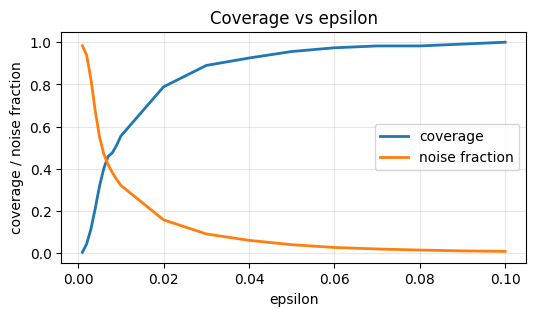

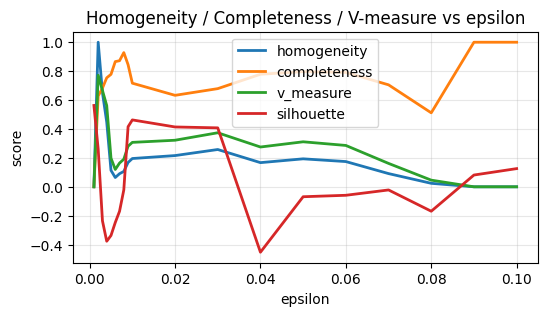

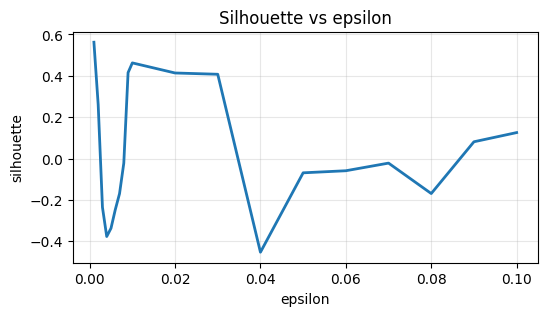

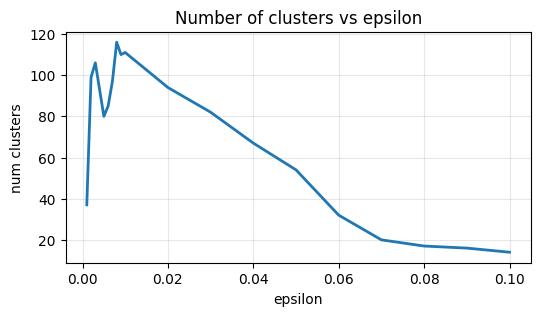

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
run_name = "model_5"
db_scan_dir = Path('../models') / run_name / 'db_scan'
csv_files = sorted(db_scan_dir.glob('clustering_results_eps_*.csv'))
best_rows = []
for f in csv_files:
    df = pd.read_csv(f)
    if 'epsilon' not in df.columns:
        eps_str = f.stem.split('clustering_results_eps_')[-1].replace('_', '.')
        try:
            df["epsilon"] = float(eps_str)
        except ValueError:
            print("ERROR")
            pass
    subset = df[df['model_file'] == 'best_model.pt'] if 'model_file' in df.columns else df
    best_rows.append(subset)

if best_rows:
    metrics_df = pd.concat(best_rows, ignore_index=True)
    metrics_df = metrics_df.sort_values('epsilon')
    out_path = db_scan_dir / f"best_model_{run_name}_epsilon_metrics.csv"
    metrics_df.to_csv(out_path, index=False)
    print(f"Saved best-model epsilon metrics to {out_path}")
else:
    print('No clustering result CSVs found.')

if best_rows:
    eps = metrics_df['epsilon']
    total_emails = getattr(data['email'], 'num_nodes', len(getattr(data['email'], 'x', []))) if 'email' in getattr(data, 'node_types', []) else len(metrics_df)
    noise_frac = metrics_df['n_noise'] / max(1, total_emails) if 'n_noise' in metrics_df.columns else None
    plt.figure(figsize=(6,3))
    plt.plot(eps, metrics_df['coverage'], linewidth=2, label='coverage')
    if noise_frac is not None:
        plt.plot(eps, noise_frac, linewidth=2, label='noise fraction')
    plt.xlabel('epsilon')
    plt.ylabel('coverage / noise fraction')
    plt.title('Coverage vs epsilon')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,3))
    for col, label in [('homogeneity','homogeneity'), ('completeness','completeness'), ('v_measure','v_measure'), ('silhouette','silhouette')]:
        if col in metrics_df.columns:
            plt.plot(eps, metrics_df[col], linewidth=2, label=label)
    plt.xlabel('epsilon')
    plt.ylabel('score')
    plt.title('Homogeneity / Completeness / V-measure vs epsilon')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,3))
    if 'silhouette' in metrics_df.columns:
        plt.plot(eps, metrics_df['silhouette'], linewidth=2)
    plt.xlabel('epsilon')
    plt.ylabel('silhouette')
    plt.title('Silhouette vs epsilon')
    plt.grid(True, alpha=0.3)
    plt.show()
    plt.figure(figsize=(6,3))
    if 'n_clusters' in metrics_df.columns:
        plt.plot(eps, metrics_df['n_clusters'], linewidth=2)
    plt.xlabel('epsilon')
    plt.ylabel('num clusters')
    plt.title('Number of clusters vs epsilon')
    plt.grid(True, alpha=0.3)
    plt.show()



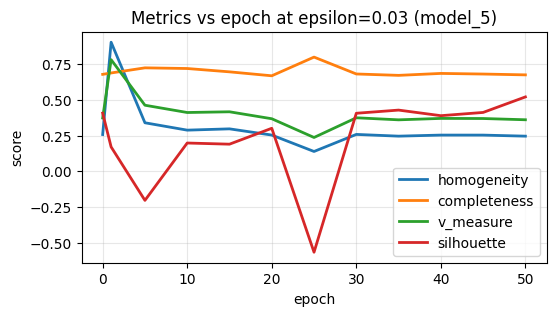

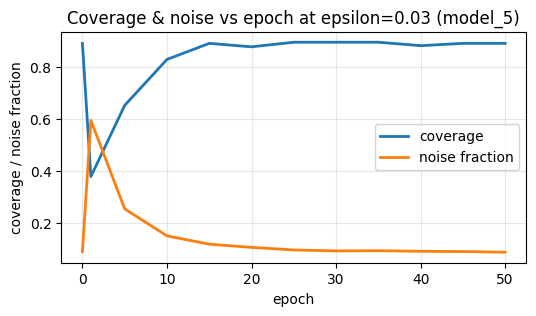

In [ ]:
import re
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

target_model = run_name  # change to another model folder as needed
target_eps = 0.03   

db_scan_dir = Path('../models') / target_model / 'db_scan'
csv_path = db_scan_dir / f"clustering_results_eps_{str(target_eps).replace('.', '_')}.csv"
if not csv_path.exists():
    print(f'CSV not found for epsilon={target_eps}: {csv_path}')
else:
    df = pd.read_csv(csv_path)
    if 'epsilon' in df.columns:
        df = df[df['epsilon'] == target_eps]
    if 'model_file' in df.columns:
        df = df[df['model_file'].notna()]
    if 'epoch' not in df.columns:
        def _extract_epoch(name):
            if isinstance(name, str):
                m = re.search(r'(?:epoch[_-]?)(\d+)', name)
                if m:
                    return int(m.group(1))
                m2 = re.search(r'(\d+)', name)
                if m2:
                    return int(m2.group(1))
            return None
        df['epoch'] = df['model_file'].apply(_extract_epoch) if 'model_file' in df.columns else None
    if df['epoch'].isna().any():
        df.loc[df['epoch'].isna(), 'epoch'] = range(len(df[df['epoch'].isna()]))
    df = df.sort_values('epoch')

    plt.figure(figsize=(6,3))
    for col, label in [('homogeneity','homogeneity'), ('completeness','completeness'), ('v_measure','v_measure'), ('silhouette','silhouette')]:
        if col in df.columns:
            plt.plot(df['epoch'], df[col], linewidth=2, label=label)
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title(f'Metrics vs epoch at epsilon={target_eps} ({target_model})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    total_emails = getattr(data['email'], 'num_nodes', len(getattr(data['email'], 'x', []))) if 'email' in getattr(data, 'node_types', []) else len(df)
    noise_frac = df['n_noise'] / max(1, total_emails) if 'n_noise' in df.columns else None
    plt.figure(figsize=(6,3))
    if 'coverage' in df.columns:
        plt.plot(df['epoch'], df['coverage'], linewidth=2, label='coverage')
    if noise_frac is not None:
        plt.plot(df['epoch'], noise_frac, linewidth=2, label='noise fraction')
    plt.xlabel('epoch')
    plt.ylabel('coverage / noise fraction')
    plt.title(f'Coverage & noise vs epoch at epsilon={target_eps} ({target_model})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


In [ ]:
epsilon_values =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

run_name = "model_5"  # Replace with your actual run folder name
pair_votes_path = "campaigns.csv"

votes_df = pd.read_csv(pair_votes_path)

# --- Extract ground-truth email pair labels ---
ground_truth_labels = extract_ground_truth_labels(votes_df)

# Run baseline clustering on raw email embeddings
baseline_results = run_baseline_clustering(
    data=data,
    epsilon_values=epsilon_values,
    ground_truth_labels=ground_truth_labels,
    out_dir=Path('../models') / run_name / 'db_scan'
)


/Users/mcandersyo/.venv-pyg/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/Users/mcandersyo/.venv-pyg/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/Users/mcandersyo/.venv-pyg/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/Users/mcandersyo/.venv-pyg/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.p

Saved baseline clustering results to ../models/model_5/db_scan/baseline_clustering_analysis.csv


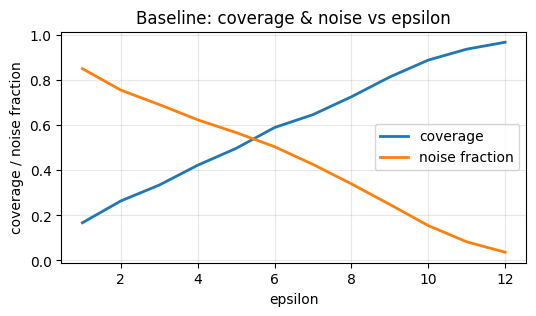

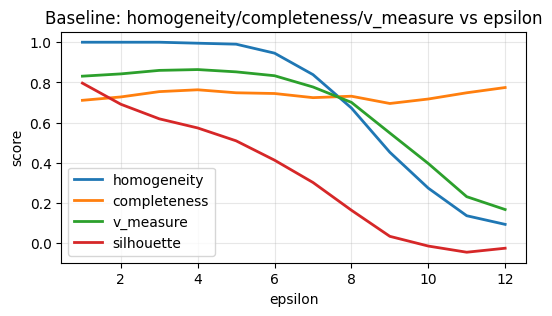

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

baseline_csv = Path('../models') / run_name / 'db_scan' / 'baseline_clustering_analysis.csv'
if baseline_csv.exists():
    bdf = pd.read_csv(baseline_csv)
    bdf = bdf.sort_values("epsilon")
    total_emails = getattr(data['email'], 'num_nodes', len(getattr(data['email'], 'x', []))) if 'email' in getattr(data, 'node_types', []) else len(bdf)
    noise_frac = bdf['n_noise'] / max(1, total_emails) if 'n_noise' in bdf.columns else None
    eps = bdf["epsilon"]
    plt.figure(figsize=(6,3))
    plt.plot(eps, bdf['coverage'], linewidth=2, label='coverage')
    if noise_frac is not None:
        plt.plot(eps, noise_frac, linewidth=2, label='noise fraction')
    plt.xlabel('epsilon')
    plt.ylabel('coverage / noise fraction')
    plt.title('Baseline: coverage & noise vs epsilon')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,3))
    for col, label in [('homogeneity','homogeneity'), ('completeness','completeness'), ('v_measure','v_measure'), ('silhouette','silhouette')]:
        if col in bdf.columns:
            plt.plot(eps, bdf[col], linewidth=2, label=label)
    plt.xlabel('epsilon')
    plt.ylabel('score')
    plt.title('Baseline: homogeneity/completeness/v_measure vs epsilon')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print(f'Baseline CSV not found: {baseline_csv}')


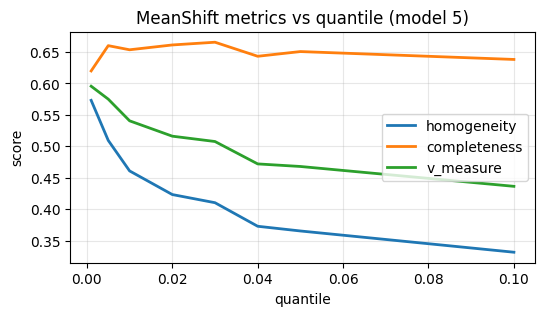

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ms_run_dir = 'model_5'
ms_csv = Path('../models') / ms_run_dir / 'meanshift' / 'meanshift_results.csv'
if ms_csv.exists():
    ms_df = pd.read_csv(ms_csv)
    ms_df = ms_df.sort_values('quantile')
    plt.figure(figsize=(6,3))
    for col, label in [('homogeneity','homogeneity'), ('completeness','completeness'), ('v_measure','v_measure')]:
        if col in ms_df.columns:
            plt.plot(ms_df['quantile'], ms_df[col], linewidth=2, label=label)
    plt.xlabel('quantile')
    plt.ylabel('score')
    plt.title('MeanShift metrics vs quantile (model 5)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print(f'MeanShift results not found: {ms_csv}')
